In [1]:
import timeit
import re
from pathlib import Path
# from itertools import product, ch

import sys
sys.path.append(str(Path.cwd().parent / "classes"))
sys.path.append(str(Path.cwd().parent))

import pandas as pd
from matplotlib import pyplot as plt

from sim_config import SimConfiguration
from simulation import Simulation
from msa import Msa


In [2]:
def scale_tree(tree_path: str, scale_factor: float, overwrite: bool=False):
    # Read the tree
    tree_path = Path(tree_path)

    with open(tree_path, 'r') as f:
        newick_str = f.read().strip()
    
    # Function to scale branch lengths in Newick string
    def scale_length(match):
        length = float(match.group(1))
        scaled = length * scale_factor
        return f":{scaled:.10f}"
    
    # Scale all branch lengths using regex
    scaled_newick = re.sub(r':([0-9.]+)', scale_length, newick_str)

    scaled_tree_path = (tree_path.parent / f"scaled_{scale_factor}.tree") if not overwrite else tree_path
    # Write the scaled tree directly
    with open(scaled_tree_path, 'w') as f:
        f.write(scaled_newick)
    return scaled_tree_path

In [ ]:
ROOT_SEQUENCE_LENGTH = 10000

TREES_PATH = Path.cwd() / "TRUE_TREES"
time_winners = []
measured_times: list[list[float]] = []



def refresh_sim(tree_file, indel_rate):
    sim_config = SimConfiguration(original_sequence_length=ROOT_SEQUENCE_LENGTH, indel_length_alpha=2.0,
                                indel_truncated_length=50,
                                rate_ins=indel_rate[0], rate_del=indel_rate[1],
                                deletion_extra_edge_length=50,
                                switch_factor=50,
                                seed=81)
    sim = Simulation(input_tree=str(tree_file), config=sim_config)

    return sim

branches_dfs = []

NUMBER_OF_WINS = 4
stop_flag = NUMBER_OF_WINS

rates = [i*0.01 for i in range(1,10)]
rates = list(zip(rates, rates[::-1]))

for RATE_MULTIPLIER in range(1,21):#[0.5, 1,2,4,8,16]:
    print(RATE_MULTIPLIER)
    for indel_rate in rates:
        if RATE_MULTIPLIER > 14 and indel_rate[0] < 0.05:
            continue
        factor_compare = {"branch_scale": [], 
                    "blocklist_time": [], "blocktree_time": [],
                    "true": [], "factor": [],
                    "insertion_rate": [indel_rate[0]], "deletion_rate": [indel_rate[1]]
                    }
        scaled_tree_path = scale_tree("scaled_trees/test_tree.txt", RATE_MULTIPLIER)
        sim = refresh_sim(scaled_tree_path, indel_rate)
        factor_compare["true"].append(len(sim.sim_nodes[1].list_of_events))
        factor_compare["factor"].append(sim.sim_nodes[1].hybrid_factor)

        blocktree_time = timeit.timeit(sim.msa_from_blocktree, number=5)
        blocklist_time = timeit.timeit(sim.msa_from_blocklist, number=5)
        factor_compare["blocklist_time"].append(blocklist_time)
        factor_compare["blocktree_time"].append(blocktree_time)
        factor_compare["branch_scale"].append(RATE_MULTIPLIER)
        comparison_df = pd.DataFrame(factor_compare)
        branches_dfs.append(comparison_df)
        print(indel_rate, blocktree_time, blocklist_time)

    # if blocktree_time < blocklist_time:
    #     stop_flag -= 1
    # else:
    #     stop_flag = NUMBER_OF_WINS
    # if stop_flag == 0:
    #     break
    # comparison_df.plot.scatter(x="factor",y="true")

15
(0.05, 0.05) 1.4036421970004085 0.728750241999478
(0.06, 0.04) 2.31096166899988 1.3378186820000337
(0.07, 0.03) 5.383813691999421 4.9536943899993275
(0.08, 0.02) 12.524333811999895 22.825996960999873
(0.09, 0.01) 28.951847015999192 123.1352617850007
16
(0.05, 0.05) 1.357080114999917 0.709349980999832
(0.06, 0.04) 2.618527302000075 1.951210440000068
(0.07, 0.03) 6.3816381430006 6.566214313999808
(0.08, 0.02) 14.655969647999882 29.723945051000555
(0.09, 0.01) 41.577633307000724 238.7365994539996
17
(0.05, 0.05) 1.466908180000246 0.7586680369986425
(0.06, 0.04) 2.743118708000111 1.7977169229998253
(0.07, 0.03) 6.983145899999727 7.818839504001517
(0.08, 0.02) 19.51871839799969 52.17766342899995
(0.09, 0.01) 48.702805162000004 418.86530219999986
18
(0.05, 0.05) 1.728591705999861 0.9514990950010542
(0.06, 0.04) 3.617438814999332 2.5035247989999334
(0.07, 0.03) 7.604867207999632 9.146621122999932
(0.08, 0.02) 22.30477168499965 74.32767770800092
(0.09, 0.01) 82.24451135500021 1057.241074103

KeyboardInterrupt: 

In [7]:
branches_df = pd.concat(branches_dfs)
# branches_df[branches_df["blocklist_time"] > branches_df["blocktree_time"]]
branches_df.reset_index

<bound method DataFrame.reset_index of    branch_scale  blocklist_time  blocktree_time  true  factor  insertion_rate  \
0            15        0.728750        1.403642   153   150.0            0.05   
0            15        1.337819        2.310962   155   150.0            0.06   
0            15        4.953694        5.383814   177   150.0            0.07   
0            15       22.825997       12.524334   186   150.0            0.08   
0            15      123.135262       28.951847   193   150.0            0.09   
0            16        0.709350        1.357080   164   160.0            0.05   
0            16        1.951210        2.618527   164   160.0            0.06   
0            16        6.566214        6.381638   194   160.0            0.07   
0            16       29.723945       14.655970   196   160.0            0.08   
0            16      238.736599       41.577633   201   160.0            0.09   
0            17        0.758668        1.466908   181   170.0         

In [8]:
branches_df.reset_index(drop=True).to_csv("comparison_extreme.csv")

In [9]:
rates = [i*0.01 for i in range(1,10)]
rates = list(zip(rates, rates[::-1]))
rates

[(0.01, 0.09),
 (0.02, 0.08),
 (0.03, 0.07),
 (0.04, 0.06),
 (0.05, 0.05),
 (0.06, 0.04),
 (0.07, 0.03),
 (0.08, 0.02),
 (0.09, 0.01)]

In [2]:
branches_df = pd.read_csv("comparison.csv", index_col=0)

In [10]:
# branches_df = branches_df.reset_index(drop=True)
branches_df[branches_df["branch_scale"] > 9]

,branch_scale,blocklist_time,blocktree_time,true,factor,insertion_rate,deletion_rate
0,15,0.728750,1.403642,153,150.0,0.05,0.05
0,15,1.337819,2.310962,155,150.0,0.06,0.04
0,15,4.953694,5.383814,177,150.0,0.07,0.03
0,15,22.825997,12.524334,186,150.0,0.08,0.02
0,15,123.135262,28.951847,193,150.0,0.09,0.01
0,16,0.709350,1.357080,164,160.0,0.05,0.05
0,16,1.951210,2.618527,164,160.0,0.06,0.04
0,16,6.566214,6.381638,194,160.0,0.07,0.03
0,16,29.723945,14.655970,196,160.0,0.08,0.02
0,16,238.736599,41.577633,201,160.0,0.09,0.01


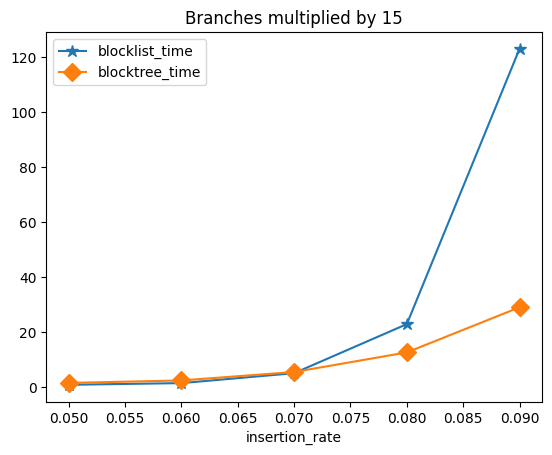

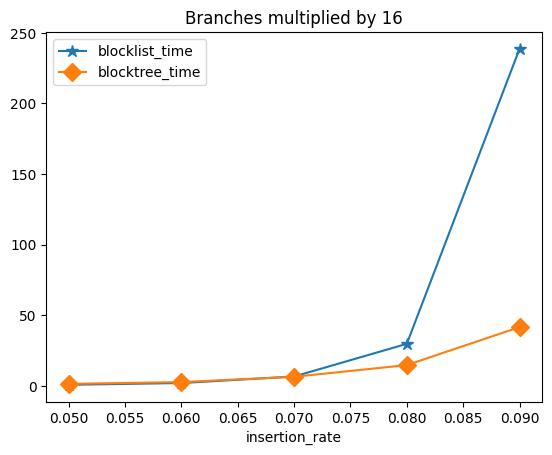

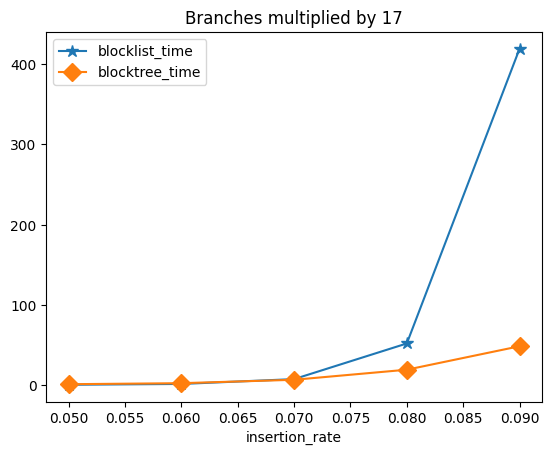

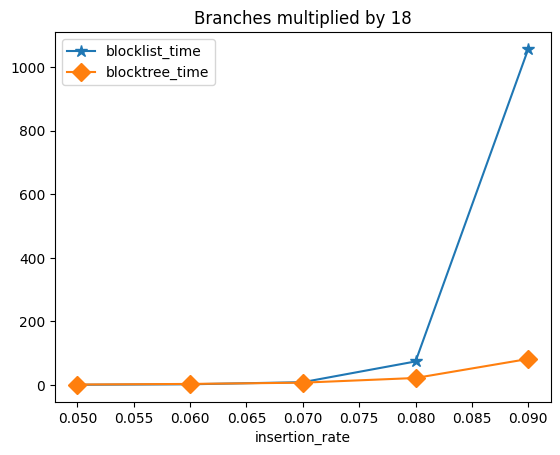

In [11]:
styles=['C0*-', 'C1D-']
for group in branches_df.groupby("branch_scale"):
    if group[0] not in [15,16,17,18]:
        continue
    group[1][["blocklist_time", "blocktree_time", "insertion_rate"]].plot(x ="insertion_rate",
                                                                          title=f"Branches multiplied by {group[0]}",
                                                                          style=styles, markersize=9)
    
    plt.savefig(f"assets/blocks_runtime_factor_{group[0]}.png" ,bbox_inches="tight", dpi=300)


In [8]:
comparison_df.corr()

,branch_scale,blocklist_time,blocktree_time,true,factor,insertion_rate,deletion_rate
branch_scale,NaN,NaN,NaN,NaN,NaN,NaN,NaN
blocklist_time,NaN,NaN,NaN,NaN,NaN,NaN,NaN
blocktree_time,NaN,NaN,NaN,NaN,NaN,NaN,NaN
true,NaN,NaN,NaN,NaN,NaN,NaN,NaN
factor,NaN,NaN,NaN,NaN,NaN,NaN,NaN
insertion_rate,NaN,NaN,NaN,NaN,NaN,NaN,NaN
deletion_rate,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
comparison_df["dist"] = (comparison_df.true - comparison_df.factor)**2

In [11]:
comparison_df.loc[comparison_df["dist"].argmax()]

branch_scale        14.000000
blocklist_time      79.535264
blocktree_time      23.447037
true               174.000000
factor             140.000000
insertion_rate       0.090000
deletion_rate        0.010000
dist              1156.000000
Name: 0, dtype: float64

In [12]:
a = -2.0

zipf_sum = sum([x**a for x in range(1,51)])
avg = sum([x*(x**a/zipf_sum) for x in range(1,51)])
avg

2.768515608139384